# Analysis

In [11]:
import pandas as pd

blocks_gdf = pd.read_pickle('./data/saint_petersburg.pickle')
blocks_gdf['site_area'] = blocks_gdf.area

In [12]:
FEATURES = ['fsi', 'gsi']
blocks_gdf['fsi'] = blocks_gdf['build_floor_area'] / blocks_gdf['site_area']
blocks_gdf['gsi'] = blocks_gdf['footprint_area'] / blocks_gdf['site_area']

In [14]:
blocks_gdf.drop(columns=['footprint_area', 'build_floor_area']).describe()

,residential,business,recreation,industrial,transport,special,agriculture,share,site_area,fsi,gsi
count,9533.000000,9533.000000,9533.000000,9533.000000,9533.000000,9533.000000,9533.000000,9399.000000,9.533000e+03,9533.000000,9533.000000
mean,0.477636,0.031249,0.198481,0.048355,0.189633,0.013287,0.013901,0.857954,1.460488e+05,0.376979,0.110118
std,0.435119,0.146300,0.340146,0.188233,0.300647,0.102915,0.106733,0.163508,3.671082e+05,0.631353,0.134133
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.710505e-20,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.775961,2.019007e+04,0.000609,0.000579
50%,0.565899,0.000000,0.000000,0.000000,0.063758,0.000000,0.000000,0.913530,4.808395e+04,0.087712,0.068645
75%,0.927143,0.000000,0.207915,0.000000,0.198971,0.000000,0.000000,0.999456,1.369371e+05,0.455139,0.160381
max,1.000000,1.000000,1.082118,1.000014,1.000002,1.000000,1.000000,1.082118,1.402941e+07,9.146449,1.101731


## ANOVA

**Вывод**: между группами (`land_use`) существуют статистически значимые различия

In [3]:
import pandas as pd
from scipy import stats
from blocksnet.enums import LandUse

def anova(column : str) -> tuple[float, float]:
    groups = []

    for land_use in LandUse:
        values = blocks_gdf[blocks_gdf.land_use == land_use][column].values
        groups.append(values)

    return stats.f_oneway(*groups)

def interpret_p_val(p_val : float) -> str:
    if p_val < 0.05:
        return 'Есть статистически значимые различия между группами'
    return 'Недостаточно доказательств, чтобы утверждать, что средние различаются'

data = []
for feature in FEATURES:
    f_val, p_val = anova(feature)
    data.append({
        'parameter': feature,
        'f_val': f_val,
        'p_val': p_val,
        'desc': interpret_p_val(p_val)
    })
    
pd.DataFrame(data).set_index('parameter')

,f_val,p_val,desc
parameter,,,
fsi,288.074613,0.0,Есть статистически значимые различия между гру...
gsi,392.012259,0.0,Есть статистически значимые различия между гру...


## Moran index

In [4]:
import geopandas as gpd
import libpysal
from esda.moran import Moran, Moran_Local

gdf = blocks_gdf.copy()

w = libpysal.weights.Queen.from_dataframe(gdf, use_index=True)
w.transform = 'r'

results = []
for param in FEATURES:
    
    moran = Moran(gdf[param], w)
    results.append({
        'parameter': param,
        "Moran_I": moran.I,
        "p_value": moran.p_sim
    })

    moran_loc = Moran_Local(gdf[param], w)
    gdf[f'{param}_moran'] = moran_loc.Is
    gdf[f'{param}_p'] = moran_loc.p_sim    

    cluster_labels = []
    for q, p_val in zip(moran_loc.q, moran_loc.p_sim):
        if p_val >= 0.05:
            cluster_labels.append(None)  # not significant
        else:
            if q == 1:
                cluster_labels.append("High-High")
            elif q == 2:
                cluster_labels.append("Low-High")
            elif q == 3:
                cluster_labels.append("High-Low")
            elif q == 4:
                cluster_labels.append("Low-Low")
    gdf[f'{param}_cluster'] = cluster_labels

/home/vasilstar/sm-imputation/.venv/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 223 disconnected components.
 There are 182 islands with ids: 157, 380, 381, 510, 944, 1260, 1425, 1443, 1465, 1921, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 2599, 2630, 3307, 3308, 3309, 3310, 3311, 3314, 3328, 3329, 3332, 3333, 3334, 3335, 3359, 3360, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3378, 3379, 3380, 3396, 3397, 3400, 3401, 3407, 3410, 3411, 3449, 3450, 3453, 3454, 3455, 3461, 3483, 3553, 3814, 3826, 3827, 3934, 3945, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4163, 4241, 4327, 4328, 4359, 4365, 4366, 4385, 4386, 4387, 4388, 4576, 4577, 4578, 4850, 4851, 5028, 5029, 5030, 5031, 5049, 5050, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5158, 5159, 5160, 5183, 

('WARNING: ', 157, ' is an island (no neighbors)')
('WARNING: ', 380, ' is an island (no neighbors)')
('WARNING: ', 381, ' is an island (no neighbors)')
('WARNING: ', 510, ' is an island (no neighbors)')
('WARNING: ', 944, ' is an island (no neighbors)')
('WARNING: ', 1260, ' is an island (no neighbors)')
('WARNING: ', 1425, ' is an island (no neighbors)')
('WARNING: ', 1443, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 1921, ' is an island (no neighbors)')
('WARNING: ', 1963, ' is an island (no neighbors)')
('WARNING: ', 1964, ' is an island (no neighbors)')
('WARNING: ', 1965, ' is an island (no neighbors)')
('WARNING: ', 1966, ' is an island (no neighbors)')
('WARNING: ', 1967, ' is an island (no neighbors)')
('WARNING: ', 1968, ' is an island (no neighbors)')
('WARNING: ', 1969, ' is an island (no neighbors)')
('WARNING: ', 1970, ' is an island (no neighbors)')
('WARNING: ', 1971, ' is an island (no neighbors)')
('WARNING: ', 197

/home/vasilstar/sm-imputation/.venv/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/vasilstar/sm-imputation/.venv/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


Интерпретация:
- `Moran_I` -- положительная слабая-умеренная (`[0.1, 0.3]`, `[0.3, 0.5]`) автокорреляция , похожие значения сгруппированы (`High-High`, `Low-Low`)
- `p_value` -- статистически значимые различия, автокорреляция реальна, а не случайна (`< 0.05`) 

In [5]:
import pandas as pd
results_df = pd.DataFrame(results).set_index('parameter')
results_df

,Moran_I,p_value
parameter,,
fsi,0.529037,0.001
gsi,0.567310,0.001


В пространстве можно выделить кластеры по отдельным параметрам

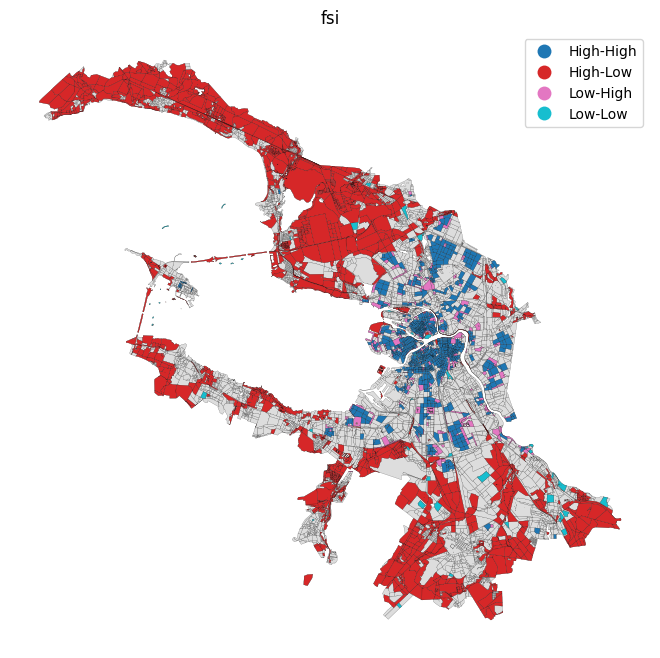

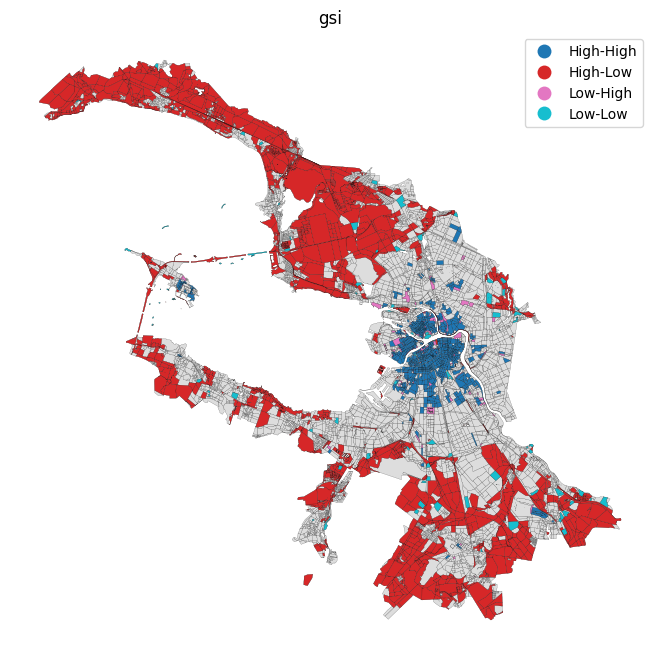

In [10]:
for feature in FEATURES:
    ax = gdf.plot(color='#ddd', figsize=(10,8), linewidth=0.1, edgecolor='black')
    gdf.plot(f'{feature}_cluster', ax=ax, figsize=(10,8), legend=True, linewidth=0.1, edgecolor='black')
    ax.set_axis_off()
    ax.set_title(feature)

## Pierson correlation

Параметры слабо зависят от `site_area` (площади застройки), но при этом хорошо коррелируют друг с другом.

In [7]:
import pandas as pd

# Выбираем колонки для анализа
params = ['site_area', *FEATURES]

# Считаем корреляционную матрицу (Пирсон)
corr_matrix = blocks_gdf[params].corr(method='pearson')
corr_matrix

,site_area,fsi,gsi
site_area,1.000000,-0.057444,-0.104026
fsi,-0.057444,1.000000,0.768988
gsi,-0.104026,0.768988,1.000000
